In [247]:
#https://www.kaggle.com/code/kumudithasilva/horse-health-multiclass-classification

In [248]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Feature Selection
from sklearn.feature_selection import mutual_info_classif

# Automated Model Selection
from lazypredict.Supervised import LazyClassifier

# Model Building
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Cross validation
from sklearn.model_selection import cross_val_score, cross_val_predict, RepeatedStratifiedKFold

# Statistical Analysis
from scipy.stats import chi2_contingency

# Hyperparameter Tuning
import optuna

# Data Spliting
from sklearn.model_selection import train_test_split

# Metrices
from sklearn.metrics import confusion_matrix

In [249]:
# Define the style
rc = {
    "axes.facecolor": "#dcf5f7",
    "figure.facecolor": "#dcf5f7",
    "axes.edgecolor": "#000000",
    "grid.color": "#094863",
    "font.family": "arial",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}
sns.set(rc=rc)

In [250]:
# import the horse_health csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [251]:
# Create copies of the train and test DataFrames
df_train = train.copy()
df_test = test.copy()

**Basic Data Exploration**

In [252]:
# This will display all columns without truncation
pd.set_option('display.max_columns', None) #display full column without .... in between

In [253]:
df_train.head(4)

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.10,132.00,24.00,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.50,decreased,distend_small,57.00,8.50,serosanguious,3.40,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.50,88.00,12.00,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.00,absent,distend_small,33.00,64.00,serosanguious,2.00,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.30,120.00,28.00,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.50,None,distend_large,37.00,6.40,serosanguious,3.40,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.10,72.00,30.00,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.00,decreased,distend_small,53.00,7.00,cloudy,3.90,yes,2208,0,0,yes,lived


In [254]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1235 non-null   object 
 8   peripheral_pulse       1235 non-null   object 
 9   mucous_membrane        1235 non-null   object 
 10  capillary_refill_time  1235 non-null   object 
 11  pain                   1235 non-null   object 
 12  peristalsis            1235 non-null   object 
 13  abdominal_distention   1235 non-null   object 
 14  nasogastric_tube       1235 non-null   object 
 15  naso

In [255]:
# Null values
columns_with_null_values = df_train.isnull().sum()
columns_with_null_values[columns_with_null_values > 0]

Series([], dtype: int64)

In [256]:
df_train.describe(include="number") #except 'object'

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.00,1235.00,1235.00,1235.00,1235.00,1235.00,1235.00,1235.00,1235.00,1235.00,1235.00,1235.00
mean,617.00,954500.40,38.20,79.57,30.05,4.38,49.60,21.39,3.29,3832.50,14.61,3.58
std,356.66,1356403.14,0.79,29.11,16.45,1.94,10.54,26.68,1.59,5436.73,193.71,88.86
min,0.00,521399.00,35.40,30.00,8.00,1.00,23.00,3.50,0.10,0.00,0.00,0.00
25%,308.50,528800.00,37.80,53.00,18.00,2.00,43.00,6.60,2.00,2205.00,0.00,0.00
50%,617.00,529777.00,38.20,76.00,28.00,4.50,48.00,7.50,3.00,2209.00,0.00,0.00
75%,925.50,534145.00,38.60,100.00,36.00,6.00,57.00,9.10,4.30,3205.00,0.00,0.00
max,1234.00,5305129.00,40.80,184.00,96.00,7.50,75.00,89.00,10.10,41110.00,3112.00,2209.00


In [257]:
# check for object data type
df_train.describe(include="object")

,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data,outcome
count,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235
unique,2,2,5,5,7,4,7,6,5,4,5,6,6,4,2,2,3
top,yes,adult,cool,reduced,pale_pink,less_3_sec,depressed,hypomotile,moderate,slight,more_1_liter,absent,distend_small,serosanguious,yes,yes,lived
freq,887,1160,700,724,284,834,429,664,543,758,604,493,482,570,929,668,574


In [258]:
# Cross check with train and test column
print(len(df_train.columns))
print(len(df_test.columns))

29
28


test.dtypes(include=['object']) filters the columns in the test DataFrame to include only those with an object data type, which is commonly used for representing categorical features.

.to_list() converts the column names to a Python list.

In [259]:
test.dtypes

id                         int64
surgery                   object
age                       object
hospital_number            int64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities       object
peripheral_pulse          object
mucous_membrane           object
capillary_refill_time     object
pain                      object
peristalsis               object
abdominal_distention      object
nasogastric_tube          object
nasogastric_reflux        object
nasogastric_reflux_ph    float64
rectal_exam_feces         object
abdomen                   object
packed_cell_volume       float64
total_protein            float64
abdomo_appearance         object
abdomo_protein           float64
surgical_lesion           object
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                   object
dtype: object

In [260]:
test.select_dtypes

<bound method DataFrame.select_dtypes of        id surgery    age  hospital_number  rectal_temp  pulse  \
0    1235      no  adult           534053        38.60  40.00   
1    1236     yes  adult           528469        38.20 112.00   
2    1237     yes  adult           528178        37.70  66.00   
3    1238      no  adult           534784        37.10  88.00   
4    1239     yes  adult           529840        38.30  50.00   
..    ...     ...    ...              ...          ...    ...   
819  2054      no  adult           529461        40.30 114.00   
820  2055     yes  adult           535338        37.20 100.00   
821  2056     yes  adult           529640        39.20 132.00   
822  2057      no  adult          5287179        38.30  54.00   
823  2058     yes  adult           528461        38.10  66.00   

     respiratory_rate temp_of_extremities peripheral_pulse mucous_membrane  \
0               20.00              normal           normal     normal_pink   
1               48.00 

.dtype is used to check the data type of a single Series within a DataFrame, while .select_dtypes() is used to filter and select columns in a DataFrame based on their data types.

In [261]:
# check with train and test column data is that any column have different value which is not match with each other

def categories_validation(train, test):
    print("The categories mismatch in training and test dataset")
    categorical_features_test = test.select_dtypes(include=['object']).columns.to_list()
    
    eqal_mismatch = []
    
    for feature in categorical_features_test:
        train_unique = set(train[feature].unique())
        test_unique = set(test[feature].unique())
        
        if train_unique != test_unique:
            eqal_mismatch.append(feature)
            
    return eqal_mismatch        

In [262]:
categories_validation(df_train, df_test)

The categories mismatch in training and test dataset


['pain', 'peristalsis', 'nasogastric_reflux', 'rectal_exam_feces']

 **Inconsistent Columns: Some columns contain inconsistent values that need to be addressed either manually or automatically by the pipeline.**

In [263]:
df_train_out = df_train.copy()

In [264]:
# Map the 'outcome' column values to numerical values for classification
df_train_out['outcome'] = df_train_out['outcome'].map({'lived': 2, 'euthanized': 1, 'died': 0})



In [265]:
df_train_out.head(4)

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.10,132.00,24.00,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.50,decreased,distend_small,57.00,8.50,serosanguious,3.40,yes,2209,0,0,no,0
1,1,yes,adult,533836,37.50,88.00,12.00,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.00,absent,distend_small,33.00,64.00,serosanguious,2.00,yes,2208,0,0,no,1
2,2,yes,adult,529812,38.30,120.00,28.00,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.50,None,distend_large,37.00,6.40,serosanguious,3.40,yes,5124,0,0,no,2
3,3,yes,adult,5262541,37.10,72.00,30.00,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.00,decreased,distend_small,53.00,7.00,cloudy,3.90,yes,2208,0,0,yes,2


**📚 Mutual Information (MI) Score:** Mutual Information (MI) is a measure of the dependence between two random variables. It quantifies how much knowing one variable can tell you about another variable. A higher MI score indicates a stronger relationship or dependency between the feature and the target variable.

In [266]:
mi_df = df_train_out.copy()

In [267]:
categorical_features = mi_df.select_dtypes(include = ['object', 'category'])
for col in categorical_features:
        mi_df[col], _ = mi_df[col].factorize()
        

Note : Before evaluating the Mutual Information (MI) score, preprocessing is essential.

Select numeric columns

Select categorical columns

Fill NAN values in the numerical columns with median

Fill NAN values in the categirical columns with factoriztion

Factorization : Factorization assigns a unique numerical code to each distinct category or label in a categorical column.

In [268]:
def encoding_numeric_categoric(dataFrame):
    # Select the numerical and categrical features
    numerical_features = dataFrame.select_dtypes(include = [np.number])
    categorical_features = dataFrame.select_dtypes(include = ['object', 'category'])
    
    # Fill missing values in numerical features with the median
    for col in numerical_features:
        dataFrame[col].fillna(dataFrame[col].median(), inplace = True)
        
    # Encode categorical features as numerical using factorization
    for col in categorical_features:
        dataFrame[col], _ = dataFrame[col].factorize()
        
            

In [269]:
# Apply encoding function to prepare the data

encoding_numeric_categoric(mi_df)

# Extract the target variable 'outcome and store it in 'mi_y'
mi_y = mi_df.pop('outcome')

In [270]:
# Define a function to compute Mutual information (MI) scores
def make_mi_score(X, y):
    
    # Compute the MI Score for features selection
    mi_score = mutual_info_classif(X, y, discrete_features='auto')
    
    # Create a series to store MI scores with feature name
    mi_features = pd.Series(mi_score, name = 'MI Score', index=X.columns).sort_values(ascending=False)
    
    return mi_features

In [271]:
mi_score = make_mi_score(mi_df, mi_y)
print(mi_score)
print(mi_score.values)

hospital_number         0.20
total_protein           0.16
lesion_1                0.16
pulse                   0.15
abdomo_protein          0.15
nasogastric_reflux_ph   0.13
pain                    0.13
packed_cell_volume      0.12
peripheral_pulse        0.07
mucous_membrane         0.07
abdomo_appearance       0.06
respiratory_rate        0.06
peristalsis             0.06
abdomen                 0.06
capillary_refill_time   0.06
abdominal_distention    0.05
temp_of_extremities     0.05
surgical_lesion         0.05
rectal_exam_feces       0.04
id                      0.04
rectal_temp             0.04
cp_data                 0.03
nasogastric_reflux      0.02
nasogastric_tube        0.01
lesion_3                0.01
surgery                 0.00
lesion_2                0.00
age                     0.00
Name: MI Score, dtype: float64
[0.19730821 0.16451841 0.15819285 0.15204354 0.14732343 0.13191168
 0.12631097 0.12060643 0.06987664 0.0678704  0.06141026 0.06047154
 0.05985432 0.05958051 

In [272]:
def plot_mi_score(score):
    
    # Define a colorful color palette for the bars
    colors = sns.color_palette('YlGnBu', n_colors=len(score))
    
    plt.figure(figsize=(13, 7))
    sns.barplot(x = score.values, y = score.index, orient='h', palette=colors)
    plt.title('Mutual Information Scores', color='black', fontweight='bold')
    plt.ylabel('Features', color='black', fontweight='bold')
    plt.xticks(rotation=40, color='red')
    
    # Add the value labels to the bars
    for index, value in enumerate(score.values):
        plt.text(value, index, f'{value:.2f}', color='black', ha='left', va='center')

    plt.tight_layout()  
    return plt.show()

        
        

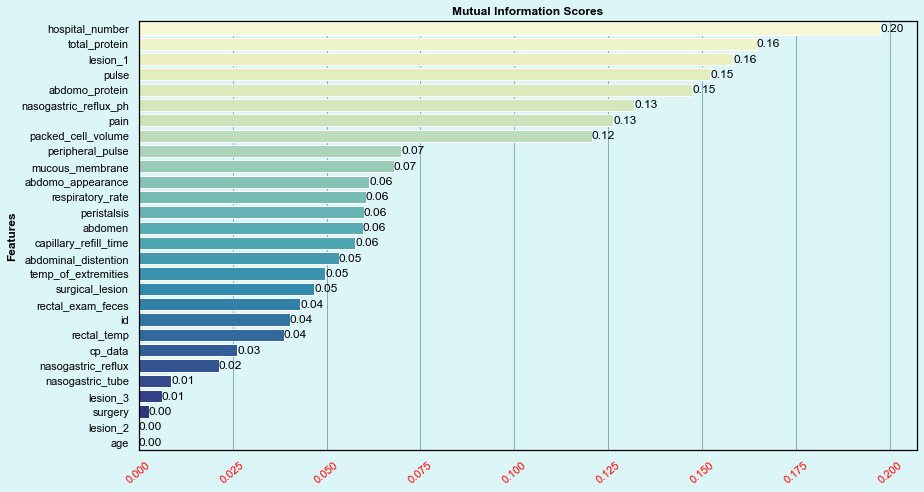

In [273]:
plot_mi_score(mi_score)

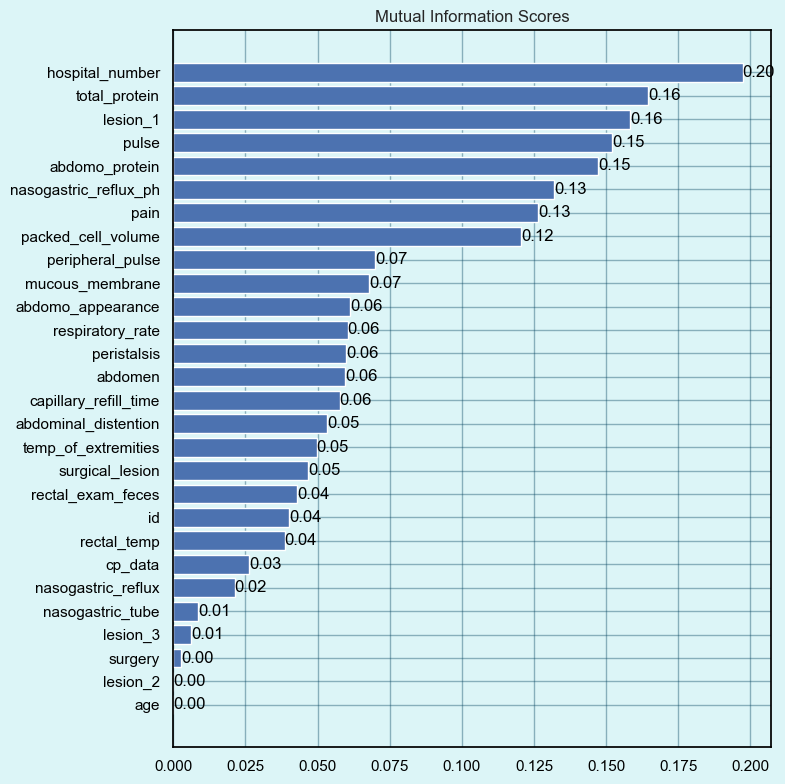

In [274]:
def plot_mi_score(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    # Add the value labels to the bars
    for index, value in enumerate(scores.values):
        plt.text(value, index, f'{value:.2f}', color='black', ha='left', va='center')

    plt.tight_layout()  
    return plt.show()
    
    
plt.figure(dpi=100, figsize=(8,8))
plot_mi_score(mi_score)    

**Auto Feature Selection**

📚 Auto Feature Selection: autofeatselect is a Python library designed to automates feature selection process. It offers various methods for calculate the feature importance scores.

In [275]:
X = df_train_out.drop('outcome', axis=1)
y = df_train_out['outcome']

In [276]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.9, random_state=42)

X.select_dtypes(include=np.number).columns.to_list() to extract the column only not value

In [277]:
numerical_features = X.select_dtypes(include=np.number).columns.to_list()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.to_list()

In [278]:
numerical_features

['id',
 'hospital_number',
 'rectal_temp',
 'pulse',
 'respiratory_rate',
 'nasogastric_reflux_ph',
 'packed_cell_volume',
 'total_protein',
 'abdomo_protein',
 'lesion_1',
 'lesion_2',
 'lesion_3']

In [279]:
feat_selectors = FeatureSelector(modeling_type='classification',
                                 X_train=X_train, y_train=y_train,
                                 X_test=X_validation, y_test=y_validation,
                                 numeric_columns=numerical_features,
                                 categorical_columns=categorical_features,
                                 seed=42
                                )

In [280]:
print("\033[34m--- LightGBM Feature Importance ---")
lgbm_feature_importance = feat_selectors.lgbm_importance(hyperparam_dict=None, objective="multiclass", return_plot=True)

--- LightGBM Feature Importance ---


TypeError: cpu_count() got an unexpected keyword argument 'only_physical_cores'

--- XGB Feature Importance ---


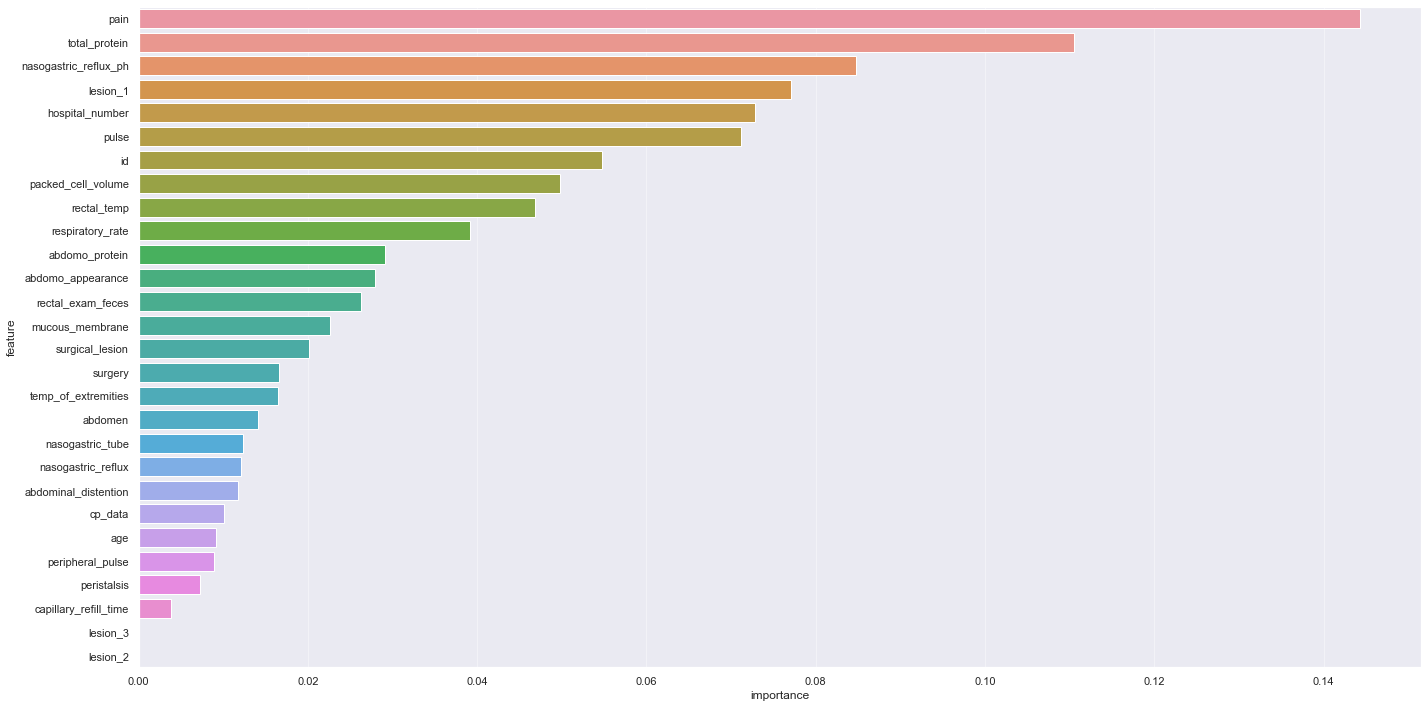

In [ ]:
print("\033[34m--- XGB Feature Importance ---")
xgb_feature_importance = feat_selectors.xgb_importance(hyperparam_dict=None, objective="multiclass", return_plot=True)

--- RandomForest Feature Importance ---


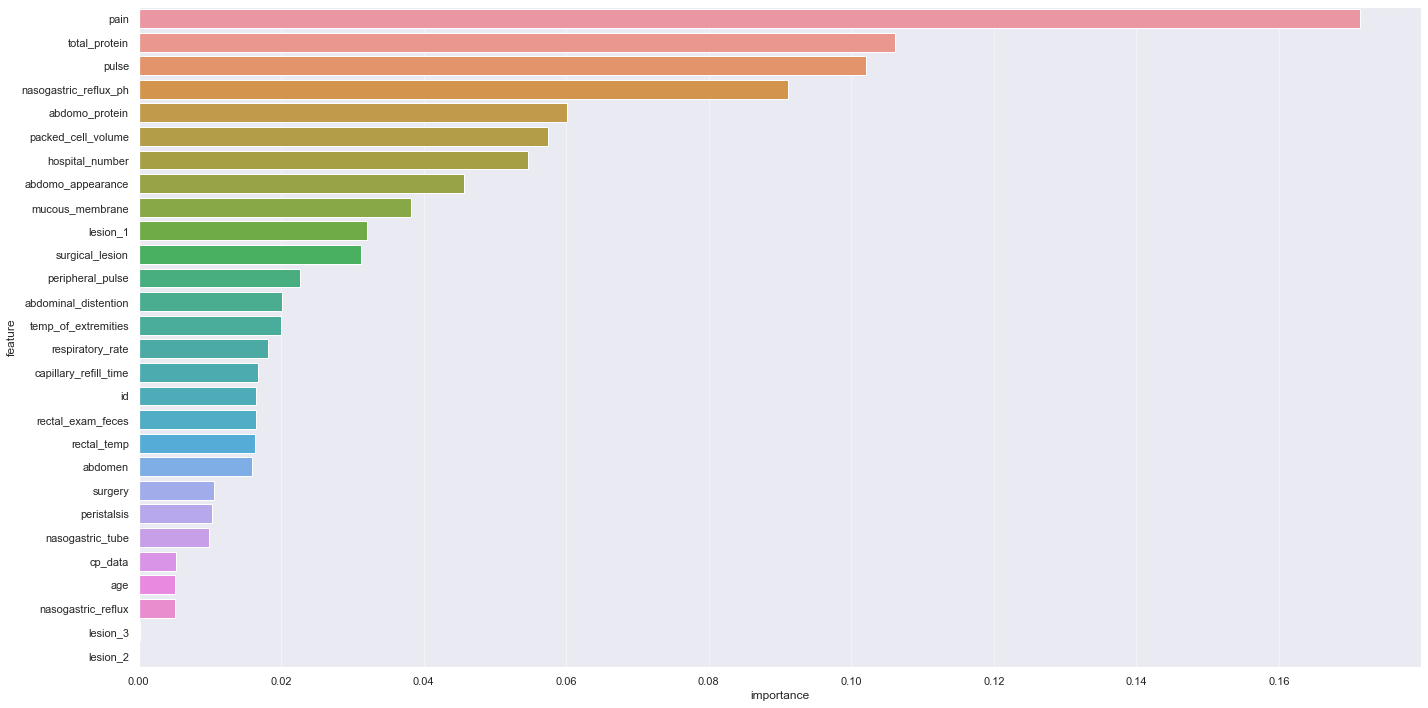

In [ ]:
print("\033[34m--- RandomForest Feature Importance ---")
xgb_feature_importance = feat_selectors.rf_importance(hyperparam_dict=None, return_plot=True)

**Exploratory Data Analysis**

Exploratory Data Analysis (EDA) is an approach to data analysis that involves summarizing and visualizing the main characteristics of a dataset to better understand its structure, patterns, and potential insights. EDA is typically performed at the beginning of the data analysis process to gain an initial understanding of the data before more advanced modeling or statistical techniques are applied.

**📚 Correation Heatmap:** The correlation heatmap is a valuable tool for gaining insights into your dataset, helping you identify relationships between variables, and potentially informing feature selection or further analysis.

A values close to 1 indicates a strong positive linear correlation, meaning that as one variable increases, the other also increases linearly.

A values close -1 indicates a perfect negative correlation, meaning that as one variable increases, the other decreases linearly.

A value of 0 indicates no linear correlation between the variables.

In [ ]:
numerical_features = train.select_dtypes(include=[np.number])    
categorical_features = train.select_dtypes(include=['object', 'category'])

In [ ]:
# Compute the correation matrix for numerical features
corr_matrix = df_train_out[numerical_features.columns].corr()

corr_matrix

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
id,1.00,-0.01,0.01,-0.01,0.01,-0.03,-0.02,0.02,0.02,0.08,-0.07,-0.03
hospital_number,-0.01,1.00,-0.00,0.12,0.09,0.11,-0.02,-0.15,0.14,0.03,0.02,-0.01
rectal_temp,0.01,-0.00,1.00,0.18,0.12,0.12,0.09,-0.06,0.04,0.02,-0.02,-0.01
pulse,-0.01,0.12,0.18,1.00,0.40,-0.01,0.44,0.00,0.06,0.00,0.02,0.03
respiratory_rate,0.01,0.09,0.12,0.40,1.00,0.00,0.19,0.00,0.00,0.02,-0.01,0.01
nasogastric_reflux_ph,-0.03,0.11,0.12,-0.01,0.00,1.00,-0.10,-0.58,0.43,0.05,-0.03,-0.02
packed_cell_volume,-0.02,-0.02,0.09,0.44,0.19,-0.10,1.00,0.18,-0.06,-0.08,0.05,0.05
total_protein,0.02,-0.15,-0.06,0.00,0.00,-0.58,0.18,1.00,-0.47,-0.11,0.04,0.02
abdomo_protein,0.02,0.14,0.04,0.06,0.00,0.43,-0.06,-0.47,1.00,0.05,0.00,-0.02
lesion_1,0.08,0.03,0.02,0.00,0.02,0.05,-0.08,-0.11,0.05,1.00,-0.01,0.00


Here's how it works:

The function np.triu(corr_matrix) takes the input corr_matrix, which is a 2D square matrix (like a correlation matrix), and returns a new matrix of the same shape.

The upper triangular part of the input matrix (including the diagonal) is preserved as it is.

The lower triangular part of the input matrix (below the diagonal) is filled with zeros.

This operation is useful when you want to focus on the unique correlations between variables and ignore the symmetric correlations (which are repeated in the upper and lower triangles of the correlation matrix).

The result of np.triu(corr_matrix) will be a matrix with zeros in the lower triangular part and the original correlation coefficients in the upper triangular part. This can be helpful for various analysis and visualization tasks to avoid redundancy and simplify interpretations of the correlation structure.

In [ ]:
import numpy as np

# Create a sample 2D array
arr = np.array([[1, 2, 3],
                [2, 5, 6],
                [3, 6, 9]])

# Use np.triu() to extract the upper triangular part
upper_triangular = np.triu(arr)

print(upper_triangular)

[[1 2 3]
 [0 5 6]
 [0 0 9]]


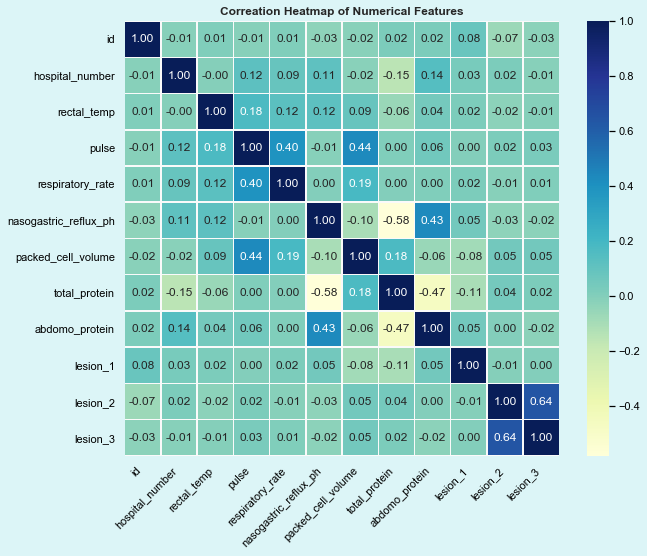

In [284]:
mask = np.triu(corr_matrix)

# Without mask

# Create the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', linewidth=0.5, square=True, linecolor='#fafafa', fmt=".2f")

# Set the plot title
plt.title('Correation Heatmap of Numerical Features', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')

plt.show()

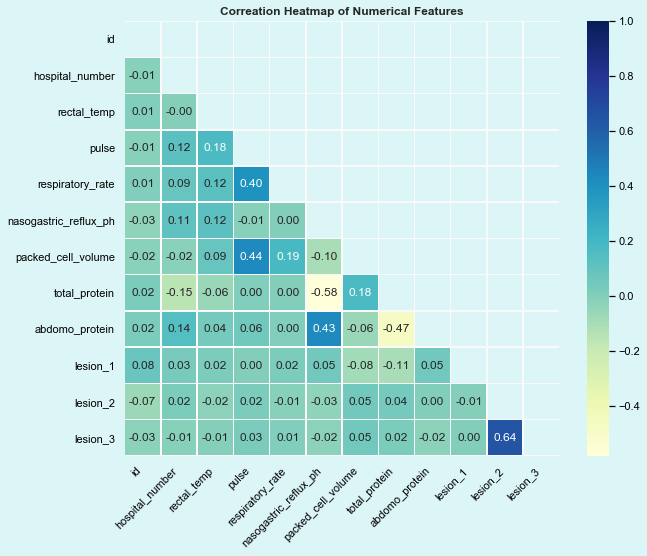

In [283]:
mask = np.triu(corr_matrix)

# With mask

# Create the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu',  mask=mask, linewidth=0.5, square=True, linecolor='#fafafa', fmt=".2f")

# Set the plot title
plt.title('Correation Heatmap of Numerical Features', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')

plt.show()

**Chi-Squared Test**

**📚 Chi-Squared Test:** The chi-squared test is a statistical hypothesis test used to determine if there is a significant association between two categorical variables. It is often used to assess whether there is a relationship between a categorical independent variables and the categorical dependent variable. The test is based on the differences between the expected and observed frequencies in a contingency table.

- Null Hypothesis (H0): There is no significant association between the two categorical variables; they are independent.

- Alternative Hypothesis (H1): There is a significant association between the two categorical variables; they are dependent.

- crosstab: Construct a contingency table that summarizes the observed counts of the data and Calculate the expected frequencies for each cell in the contingency table under the assumption that the variables are independent

- chi-squared: Calculate the difference between the observed and expected frequencies.

- p-value: Calculate the p-value associated with the test statistic. The p-value represents the probability of observing a test statistic

Compare the p-value to a predetermined significance level (e.g., 0.05). If the p-value is less than the significance level, reject the null hypothesis that means there is significant association between the two categorical variables. If there is no significant association between the two categorical variables null hypothesis is accepted. So based on this we can exclude the features that have values higher than the predetermined significance level.